##Task 3

###Question 1

In [3]:
def display(img, colormap=cm.Greys):
    plt.imshow(img, cmap = colormap)
    plt.show()

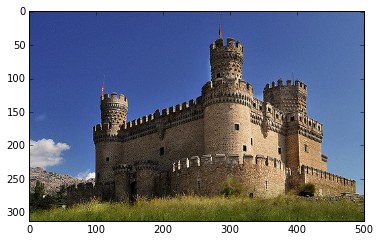

In [4]:
# read in and display
def readImg(name):
    img = np.array(misc.imread("./Images/Q3/"+name))/255.0
    return img
img = readImg("castle.jpg")
display(img)

In [13]:
# get width and height and find s
def getMN(img):
    m,n = img.shape[0], img.shape[1]
    return m,n

def getS(k,m,n):
    s = np.ceil(math.sqrt(m*n/k))
    return s

In [14]:
def getAllPairs(m, n):
    return np.array(list((product(xrange(m),xrange(n)))))

In [15]:
# convert image to feature vector (rgb/lab and xy) 
# include 2 extra columns for storing class and distance from center
def getFeaturesForImage(img, allpairs, m, n):
    features_list = []
    # iterate through all points of the image
    for ptxy in allpairs:
        features_list.append(np.concatenate([img[ptxy[0],ptxy[1]],ptxy]))
    features = np.array(features_list)
    dist_class_cols = np.full((m*n,2),-1,dtype='float')
    features = np.hstack((features, dist_class_cols))
    features_shaped = features.reshape(m,n,7)
    return features_shaped

In [22]:
# choose k centers by creating a regular grid
def getSeedKCenters(k,m,n,displayCenters=False):
    s = getS(k,m,n)
    kcenters = []
    x_ct = int(np.ceil(m/s))
    y_ct = int(np.ceil(n/s))
    x_space = int(np.ceil(m/x_ct))
    y_space = int(np.ceil(n/y_ct))
    pt_count = 0
    for i in np.arange(x_ct):
        x = int(np.floor((i+0.5)*x_space))

        for j in np.arange(y_ct):
            y = int(np.ceil((j+0.5)*y_space))
            kcenters.append([x,y])
            pt_count += 1

    kcenters = np.array(kcenters)
    # remove extra centers
    kcenters = np.delete(kcenters, random.sample(range(k), ((x_ct*y_ct)-k)), axis=0)

    # randomly generated version
    #     allpairs = getAllPairs(m, n)
    #     kcenters = np.array(allpairs, copy=True)
    #     np.random.shuffle(kcenters)
    #     kcenters = kcenters[0:k]

    # display the centers
    if(displayCenters):
        implot = plt.imshow(img)
        plt.scatter(x=kcenters[:,1], y=kcenters[:,0], c='r', s=10)
        plt.show()

    return kcenters

# getSeedKCenters(200,m,n,True)
# print "The seeds are shown above. They are a grid with extra elements removed"

In [23]:
# create a list of features for the k centers. this list's values can be updated iteratively
def getFeaturesForSeeds(kcenters, features_shaped):
    center_ftrs = []
    for kcenter in kcenters:
        center_ftrs.append(features_shaped[kcenter[0],kcenter[1]])
    center_ftrs = np.array(center_ftrs)
    return center_ftrs

In [24]:
# method to calculate distance between 2 features
# Reference: http://www.stat.ucla.edu/~yuille/courses/Stat238-Winter14/Lecture4(2014).pdf
def getDistance(pt_a, pt_b,s,m=1):
    color_dist = np.linalg.norm(pt_a[0:3]-pt_b[0:3])
    spatial_dist = np.linalg.norm(pt_a[3:5]-pt_b[3:5])
    return (color_dist + (m/s)*spatial_dist)

In [25]:
# return the total distance between current center features and new center features
# it is converged if the total distance is 0
def getConvergeDistance(ftrs, new_ftrs, s, k, pos_dist_weight):
    dist = 0
    for i in np.arange(k):
        dist += getDistance(ftrs[i], new_ftrs[i], s, pos_dist_weight)
    return dist

In [26]:
# get a 2S*2S window coordinates
def getWindow(center,s,m,n):
    startx, starty = max(int(np.round(center[3]-s)),0), max(int(np.round(center[4]-s)),0)
    endx, endy = min(int(np.round(center[3]+s)),m-1), min(int(np.round(center[4]+s)),n-1)
    return startx, starty, endx, endy

In [27]:
# iterate through each pixel and assign classes to each pixel from the k centers
def assignPixelClassesDistances(center_ftrs, features_shaped, s, m, n):
    # assign pixels to classes based on minimum distance calculated
    for idx, center_ftr in enumerate(center_ftrs):
        # get the features for the center to compare other pixels with as center_ftr

        # then, get the start and stop indices for the 2S*2S window
        startx, starty, endx, endy = getWindow(center_ftr, s, m, n)

        # iterate through the window
        for i in np.arange(startx, endx):
            for j in np.arange(starty, endy):
                # get feature for current pixel
                ftr = features_shaped[i,j]
                # get distance from current center
                dist = getDistance(ftr, center_ftr,s)
                # compare with existing minimum distance of pixel
                min_dist = ftr[5]
                if min_dist<0 or dist<min_dist:
                    # set lowest distance to dist and class to idx if dist < min_dist
                    ftr[5] = dist
                    ftr[6] = idx

In [28]:
# calculating new k values
def getNewCenters(features_shaped, allpairs, k):
    # this stores the pixel-count for each center and 
    # the sum of features, which will eventually be averaged
    avg_centers = np.zeros((k,6))

    # iterate through points
    for ptxy in allpairs:
        ftr = features_shaped[ptxy[0],ptxy[1]]
        class_idx = ftr[6]
        current_ctr = avg_centers[class_idx]
        for i in np.arange(5):
            # increment by the respective feature
            current_ctr[i] += ftr[i]
        # increment match count
        current_ctr[5] += 1

    # average the features with the match count and assign to center_ftrs
    return avg_centers[:,0:5]/avg_centers[:,5][:,None]

In [158]:
# perform spic algorithm
def sic(img, k, pos_dist_weight=10, max_iterations=30):
    # get m, n and s
    m,n = getMN(img)
    s = getS(k,m,n)

    # get all x,y pairs. this is useful for iterations
    allpairs = getAllPairs(m, n)
    
    # get features for the image
    features_shaped = getFeaturesForImage(img, allpairs, m, n)

    # initialize centers
    kcenters = getSeedKCenters(k,m,n)
    center_ftrs = getFeaturesForSeeds(kcenters, features_shaped)

    # run the algorithm
    convergence_distance = 10000 #initialize to a high value
    iteration = 0
    
    #iterate until convergence or max_iteration
    while(convergence_distance>0 and iteration<max_iterations):
        assignPixelClassesDistances(center_ftrs, features_shaped, s, m, n)
        
        # store the distances post-initialization
        if(iteration==0):
            post_initialization_heatmap = np.array(features_shaped[:,:,5], copy=True)
        
        center_ftrs_new = getNewCenters(features_shaped, allpairs, k)
        convergence_distance = getConvergeDistance(center_ftrs_new, center_ftrs, s, k, pos_dist_weight)
        # print "Current convergence distance:",convergence_distance,"iteration:", iteration+1

        # set average centers to new average centers and reduce iteration count
        center_ftrs = center_ftrs_new
        iteration += 1
    
    return features_shaped, post_initialization_heatmap

###Question 2

Our initial tests will incorporate a simple feature vector, similar to the Mean-Shift method:
f = (r g b x y)T . What will be a good distance metric for measuring similarity
between a pixel and the center in this 5D space? Explain your choice.

For the distance measure, we use the getDistance method. Here, we calculate color distance (considering only r, g and b values) and pixel distance (only x and y values) separately and combine the values using a weight value m. The greater the value of m, the greater the impact of spatial proximity and the more compact the cluster. A value is between 1 and 20 is found to be suitable and a value of 10 works fairly well. We display the results for m=10 and k=128 below.

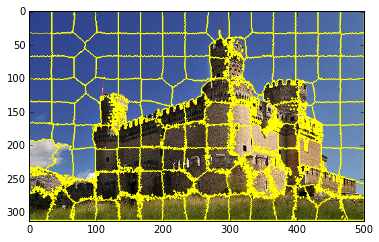

In [132]:
# trial
output_img, initialization_heatmap = slick(img,128,10)
# display image
segments = output_img[:,:,6]
display(mark_boundaries(img, segments.astype('int')))

### Question 3

We display the results for k = 128 and m = 1, 10, 20. As m increases, the weightage given to spatial distance increases producing different results

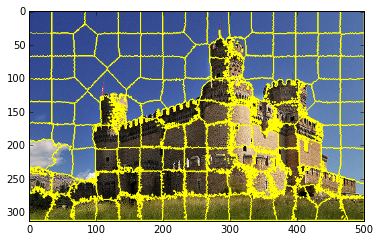

In [134]:
# m = 1
output_img1, initial_heatmap1 = slick(img, 128, 1)
segments1 = output_img1[:,:,6]
display(mark_boundaries(img, segments1.astype('int')))

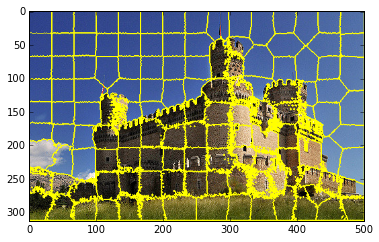

In [135]:
# m = 15
output_img15, initial_heatmap15 = slick(img, 128, 15)
segments15 = output_img15[:,:,6]
display(mark_boundaries(img, segments15.astype('int')))

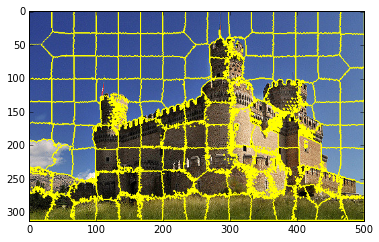

In [136]:
# m = 30
output_img30, initial_heatmap30 = slick(img, 128, 30)
segments30 = output_img30[:,:,6]
display(mark_boundaries(img, segments30.astype('int')))

### Question 4

It is noticed that in each of the initial heatmaps, the grids are clearly visible, while in the converged image, the grid is more distorted. We also notice that the initial images have a lot more green areas in them. This is because the distance of pixels from the center points has not yet been minimized via k-means.

In [117]:
# method to plot heatmaps
def plotHeatmap(img):
    fig = plt.imshow(img, cmap = cm.jet)
    ax = fig.axes
    ax.axis('off')
    cb = plt.colorbar(boundaries=np.arange(0, 1, 0.1))
    cb.set_clim(vmin=0, vmax=1)
    plt.show()

In [119]:
def displayHeatmaps(pre, post, k, m):
    print "Initial Heatmap (Top) and Post-Convergence Heatmap (bottom) for k =",k,"and m =",m
    final_heatmap = np.array(post, copy=True)
    initial_heatmap = np.array(pre, copy=True)
    final_heatmap[final_heatmap < 0] = 0
    initial_heatmap[initial_heatmap < 0] = 0
    final_heatmap = final_heatmap/np.max(final_heatmap)
    initial_heatmap = initial_heatmap/np.max(initial_heatmap)
    plotHeatmap(initial_heatmap)
    plotHeatmap(final_heatmap)
 

Initial Heatmap (Top) and Post-Convergence Heatmap (bottom) for k = 128 and m = 1


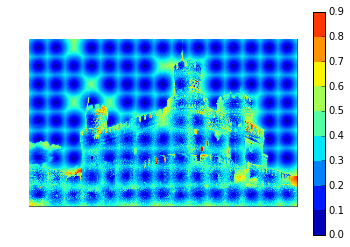

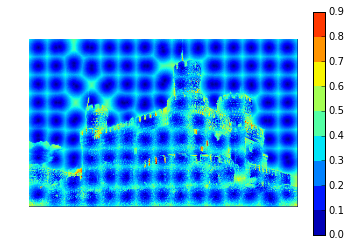

In [137]:
displayHeatmaps(initial_heatmap1, output_img1[:,:,5], 128, 1)

Initial Heatmap (Top) and Post-Convergence Heatmap (bottom) for k = 128 and m = 15


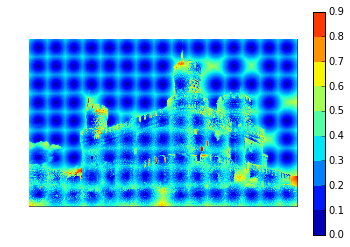

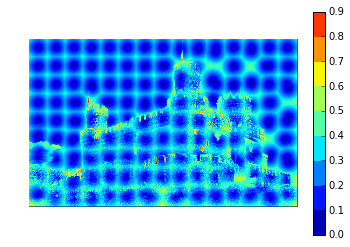

In [138]:
displayHeatmaps(initial_heatmap15, output_img15[:,:,5], 128, 15)

Initial Heatmap (Top) and Post-Convergence Heatmap (bottom) for k = 128 and m = 30


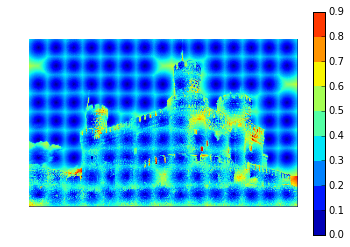

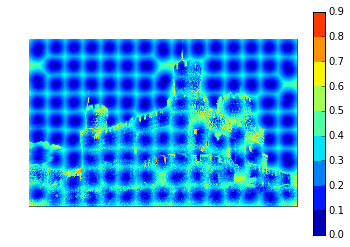

In [139]:
displayHeatmaps(initial_heatmap30, output_img30[:,:,5], 128, 30)

###Question 5

It is seen from the timings below that the time peaks for k = 64 and reduces thereafter. This could be because in our algorithm, if we increase the number of k, the sampling window size reduces in a proportional manner. So, we can expect that for an image, the value of k has an optimal value for which the timing is minimum

In [140]:
from timeit import Timer

for k in [16, 64, 256, 1024]:
    t = Timer(lambda: slick(img, 128, k))
    print "\n\nTime for k =",k,"is:",t.timeit(number=1)



Time for k = 16 is: 157.853346109


Time for k = 64 is: 188.616082191


Time for k = 256 is: 153.613694906


Time for k = 1024 is: 149.59525609


###Question 6

In [243]:
def do_recall_measure(slic_img, gte_img):
    y_true = np.ravel(gte_img)
    y_pred = np.ravel(slic_img)
    precision, recall, fbeta_score, support = precision_recall_fscore_support(y_true, y_pred,average='binary')
    return recall

###Question 7

In [239]:
# we use gala to measure the undersegmentation error as the manual method is too slow
# https://github.com/janelia-flyem/gala
def do_undersegmentation_measure(slic_seg_img, gts_img):
    return ev.split_vi(slic_seg_img, gts_img)[0]

### Question 8

We set up the experiment so that we can run on both the library slic function and our own slic function. We perform preliminary results using the library function for faster performance

In [241]:
# Function to read in images and ground truth edges and segments
img_names = ["10081", "17067", "33044", "41096", "5096", "69007", "78098", "81095", "14085", "20069", "35028", "43033", "51084", "69022", "79073", "14092", "2018", "35049", "43051", "6046", "70011", "80085", "15011", "23050", "36046", "45000", "61034", "70090", "80090", "15062", "28083", "41006", "48017", "64061", "71076", "8068", "16004", "29030", "41029", "48025", "65084", "71099", "81066", "16068", "3063", "41085", "49024", "69000", "77062", "81090"]

def thicken_edge(edge_img): 
    k = np.array([[0,0,0,1,0,0,0], 
                  [0,0,1,1,1,0,0],
                  [0,1,1,1,1,1,0],
                  [1,1,1,1,1,1,1],
                  [0,1,1,1,1,1,0],
                  [0,0,1,1,1,0,0], 
                  [0,0,0,1,0,0,0]])
    thick_img = signal.convolve2d(edge_img, k, boundary='symm', mode='same')
    w, h = thick_img.shape[0], thick_img.shape[1]
    thick_img = thick_img.reshape(h*w)
    thick_img[thick_img>0] = 1
    thick_img = thick_img.reshape(w,h)
    return thick_img

def readBSDImgs(idx):
    img = np.array(misc.imread("./Images/Q3/BSDS/"+img_names[idx]+".jpg"))/255.0
    
    gte_imgs = []
    gts_imgs = []
    for i in np.arange(1,6):
        gte_imgs.append(thicken_edge(np.array(misc.imread("./Images/Q3/BSDS/"+img_names[idx]+"_e"+str(i)+".bmp"))/255.0))
        gts_imgs.append(np.array(misc.imread("./Images/Q3/BSDS/"+img_names[idx]+"_s"+str(i)+".tif")))
        
    return img, gte_imgs, gts_imgs

In [272]:
k_vals = [16,64,256,1024]
# k_vals = [256]

def get_all_measurements(n_imgs, is_custom=False):
    time_diffs = []
    recall_measures = []
    underscore_measures = []

    for k in k_vals:

        time_diff = 0
        recall_measure = 0
        underscore_measure = 0

        for i in np.arange(n_imgs):
            img, gte_imgs, gts_imgs = readBSDImgs(i)

            # start measuring time
            start_time = timeit.timeit()
            
            if(is_custom):
                slick_img, slick_heatmap = slick(img, k, 10)
                slick_segments = slick_img[:,:,6]
            else:
                # use library method initially for performance
                slick_segments = slic(img, k, sigma = 1)
                
            slick_segments[slick_segments<0] = 0

            # stop measuring time     
            end_time = timeit.timeit()

            t = start_time - end_time

            # display(mark_boundaries(img, slick_segments.astype('int')))
            slick_edge_img = find_boundaries(slick_segments)

            r = 0
            u = 0
            for j in np.arange(5):
                r = r + do_recall_measure(slick_edge_img, gte_imgs[j])
                u = u + do_undersegmentation_measure(slick_segments, gts_imgs[j])
            r = r/5.0
            u = u/5.0

            time_diff = time_diff + t
            recall_measure = recall_measure + r
            underscore_measure = underscore_measure + u

        time_diff = time_diff / n_imgs
        recall_measure = recall_measure / n_imgs
        underscore_measure = underscore_measure / n_imgs

        time_diffs.append(time_diff)
        recall_measures.append(recall_measure)
        underscore_measures.append(underscore_measure)
    
    return time_diffs, recall_measures, underscore_measures

In [264]:
time_lib, recall_lib, undersegmentation_lib = get_all_measurements(len(img_names))

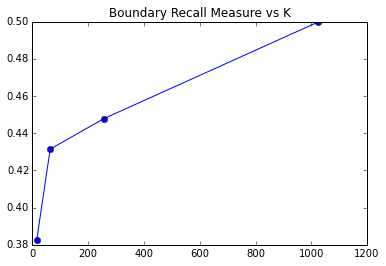

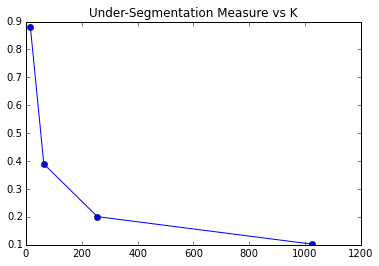

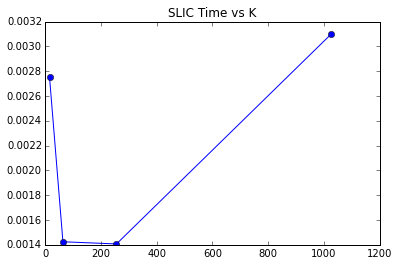

In [265]:
# plotting
def plotmeasures(vals, k_vals, title):
    plt.title(title)
    plt.plot(k_vals, vals, '-o')
    plt.show()

plotmeasures(recall_lib, k_vals,"Boundary Recall Measure vs K")
plotmeasures(undersegmentation_lib, k_vals,"Under-Segmentation Measure vs K")
plotmeasures(time_lib, k_vals,"SLIC Time vs K")

In [ ]:
time_full, recall_full, undersegmentation_full = get_all_measurements(len(img_names), True)

Based on the graphs above, we note that Boundary Recall Measurement increases with K and Under Segmentation Measurement decreases with K as expected. We also observe a saturating effect. So, increasing K beyond a point will not improve performance.

For time, we seem to get arbitrary values. This could be because the time taken is a balance between the sample size and the number of clusters.

###Problem 9

Owing to performance constraints of local machine, we only use our custom built SLIC method for running with 3 images. We get the measurements as per below.

In [267]:
time_custom, recall_custom, undersegmentation_custom = get_all_measurements(3, True)

In [268]:
print time_custom, recall_custom, undersegmentation_custom

[0.005571206410725911] [0.27878106131567487] [0.20880824955766666]


To improve performance, we can use the LAB color space instead of RGB. Also, another problem is that the periodic nature of the initial grid is unnatural.

In [233]:
# Imports
# http://www.pyimagesearch.com/2014/07/28/a-slic-superpixel-tutorial-using-python/
%matplotlib inline
import numpy as np
from itertools import product
import math
import scipy
from scipy import signal
from scipy import misc
from matplotlib import pylab as plt
import matplotlib.cm as cm
import cv2
from scipy import ndimage
from scipy import misc
from sklearn.utils import shuffle
from sklearn import cross_validation
from sklearn.cluster import KMeans
from skimage.feature import canny
import random
from skimage.segmentation import mark_boundaries
from skimage.segmentation import slic, join_segmentations
from skimage.segmentation import find_boundaries
from sklearn.metrics import precision_recall_fscore_support
from gala import evaluate as ev
import timeit